In [34]:
import os
import cv2
import glob
from datetime import datetime
import csv
import numpy as np
from spikeinterface.extractors import OpenEphysBinaryRecordingExtractor  # Import OpenEphysBinaryRecordingExtractor

# Base folder containing the .avi files
base_folder = r"S:\Sachuriga\Ephys_Vedio\CR_CA1\pytorch_model"

# Target base folder to search for matching folders
target_base = r"S:\Sachuriga\Ephys_Recording\CR_CA1"

# Output CSV file path
output_csv = os.path.join(target_base, "video_processing_results.csv")

# Function to extract components from .avi file name
def extract_components(file_name):
    parts = file_name.split("_")

    # Animal number: First five letters
    animal_number = file_name[:5]

    # Recording day
    recording_day = None
    for part in parts:
        if "T" in part and any(part.startswith(prefix) for prefix in ["20", "A20", "B20", "C20"]):
            date_str = part.split("T")[0]
            print(f"Debug: Trying to parse date from '{date_str}'")
            if date_str.startswith(("A", "B", "C")):
                date_str = date_str[1:]  # Strip session prefix
            try:
                dt = datetime.strptime(date_str, "%Y-%m-%d")
                recording_day = dt.strftime("%Y-%m-%d")
                print(f"Debug: Successfully parsed recording day as '{recording_day}'")
                break
            except ValueError as e:
                print(f"Debug: Failed to parse date '{date_str}': {e}")
                continue

    # Recording session
    recording_session = None
    for part in parts:
        if part in ["A", "B", "C"]:
            recording_session = part
            break
    if not recording_session:
        if "A20" in file_name and file_name[file_name.index("A20") + 1].isdigit():
            recording_session = "A"
        elif "B20" in file_name and file_name[file_name.index("B20") + 1].isdigit():
            recording_session = "B"
        elif "C20" in file_name and file_name[file_name.index("C20") + 1].isdigit():
            recording_session = "C"

    # Extract time
    time_part = "00-00-00"
    for part in parts:
        if "T" in part:
            time_part = part.split("T")[1].replace("_", "-")[:8]
            break

    return animal_number, recording_day, recording_session, time_part

# Function to search for matching target folder (still needed for states.npy check)
def search_target_folder(target_base, animal_number, recording_day, recording_session):
    if recording_day is None or recording_session is None:
        return None
    search_path = os.path.join(target_base, animal_number, f"{animal_number}_{recording_day}_*_{recording_session}")
    matching_folders = glob.glob(search_path)
    if matching_folders:
        return matching_folders[0]  # Return the first match
    return None

# Function to search for matching phy_k folder directly under target_base
def search_phy_folder_from_target_base(target_base, animal_number, recording_day, recording_session):
    if recording_day is None or recording_session is None:
        return None
    search_phy_path = os.path.join(target_base, animal_number, f"{animal_number}_{recording_day}_*_{recording_session}_phy_k")
    phy_folders = glob.glob(search_phy_path)
    if phy_folders:
        return phy_folders[0] # Return the first match
    return None


# Function to check frame count match with states.npy using OpenEphysBinaryRecordingExtractor
def check_frame_count_match(target_folder, total_frames):
    if not target_folder:
        print("Warning: No target folder provided, frame count check skipped.")
        return "No Target Folder", "Unknown" # Return "Unknown" for TTL count

    try:
        stream_names = OpenEphysBinaryRecordingExtractor.get_streams(target_folder)[0][0]
        if not stream_names:
            print(f"Warning: No streams found in target folder {target_folder}")
            return "No Streams Found", "Unknown" # Return "Unknown" for TTL count

        stream_name = stream_names # Assuming the first stream is the correct one
        print(fr"Merging step_Before mannual search the stream_name. Auto search result is {stream_name}")

        record_node = stream_name.split("#")[0]
        aquisition_sys = stream_name.split("#")[1]
        print(fr"the node is {record_node}, the sys is {aquisition_sys}")
        states_npy_path = os.path.join(target_folder, fr"{record_node}/experiment1/recording1/events/{aquisition_sys}/TTL/states.npy")


        if not os.path.exists(states_npy_path):
            print(f"Warning: states.npy file not found at {states_npy_path}, frame count check skipped.")
            return "states.npy Not Found", "Unknown" # Return "Unknown" for TTL count

        states_data = np.load(states_npy_path)
        ttl_count = np.sum((states_data == -3) | (states_data == -6))
        frame_diff = abs(ttl_count - total_frames)
        is_match = frame_diff < 10
        return "Match" if is_match else "Not Match", ttl_count # Return match status and ttl_count
    except Exception as e:
        print(f"Error loading or processing states.npy from {target_folder}: {e}") # Modified error message to include folder
        return "Error Processing states.npy", "Unknown" # Return "Unknown" for TTL count


# Process all .avi files in the base folder
if not os.path.exists(base_folder):
    print(f"Base folder {base_folder} does not exist.")
    exit()

# List all .avi files
avi_files = [f for f in os.listdir(base_folder) if f.endswith('.avi')]

# List to store results
results = []

if not avi_files:
    print(f"No .avi files found in {base_folder}.")
else:
    print(f"Processing {len(avi_files)} .avi files in {base_folder}:")
    print("-" * 80)

    for avi_file in avi_files:
        full_avi_path = os.path.join(base_folder, avi_file)

        # Extract components
        animal_number, recording_day, recording_session, time_part = extract_components(avi_file)

        # Open the video file using OpenCV
        video = cv2.VideoCapture(full_avi_path)
        if not video.isOpened():
            print(f"Error: Could not open video {avi_file}")
            total_frames = "Unknown"
        else:
            total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            video.release()

        # Search for the target folder (still for states.npy check)
        target_folder = search_target_folder(target_base, animal_number, recording_day, recording_session)

        # Search for phy_k folder directly from target_base
        target_phy_folder_path = search_phy_folder_from_target_base(target_base, animal_number, recording_day, recording_session)


        frame_count_match_result, ttl_count = "Phy Folder Not Found", "Unknown" # default values if phy folder not found in either location
        if target_folder and target_phy_folder_path: # Only check frame count if both target and phy folder exist now as per requirement
            frame_count_match_result, ttl_count = check_frame_count_match(target_folder, total_frames) # Use original target folder for states.npy check
        elif not target_phy_folder_path:
            frame_count_match_result, ttl_count = "Phy Folder Not Found", "Unknown" # Explicitly mark as phy folder not found if only phy folder is missing
        elif not target_folder:
            frame_count_match_result, ttl_count = "No Target Folder", "Unknown" # keep original no target folder response


        # Print results
        print(f"File: {avi_file}")
        print(f"Animal number: {animal_number}")
        print(f"Recording day: {recording_day}")
        print(f"Recording session: {recording_session}")
        print(f"Total frames: {total_frames}")
        if target_folder:
            print(f"Matched target folder: {target_folder}")
        else:
            print(f"Matched target folder: None (no folder found matching {animal_number}_{recording_day or 'None'}_*_{recording_session or 'None'})")

        if target_phy_folder_path:
            print(f"Matched Phy folder: {target_phy_folder_path}")
        else:
            print(f"Matched Phy folder: None")

        print(f"Frame Count Match: {frame_count_match_result}") # Print frame count match result
        print(f"TTL Count: {ttl_count}") # Print TTL count
        print("-" * 80)

        # Append result to list
        results.append({
            "File": avi_file,
            "Animal_number": animal_number,
            "Recording_day": recording_day if recording_day else "None",
            "Recording_session": recording_session if recording_session else "None",
            "Total_frames": total_frames,
            "Matched_target_folder": target_folder if target_folder else "None",
            "Matched_phy_folder": target_phy_folder_path if target_phy_folder_path else "None", # Add phy folder path
            "Time": time_part,
            "Frame_count_match": frame_count_match_result, # Add frame count match result to results
            "TTL_count": ttl_count # Add TTL count to results
        })

    # Write results to CSV
    headers = ["File", "Animal_number", "Recording_day", "Recording_session", "Total_frames", "Matched_target_folder", "Matched_phy_folder", "Time", "Frame_count_match", "TTL_count"] # Add new header
    with open(output_csv, mode='w', newline='', encoding='utf-8') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        writer.writeheader()
        writer.writerows(results)
    print(f"Results saved to {output_csv}")

print("Processing complete.")

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing 318 .avi files in S:\Sachuriga\Ephys_Vedio\CR_CA1\pytorch_model:
--------------------------------------------------------------------------------
Debug: Trying to parse date from 'A2024-07-13'
Debug: Successfully parsed recording day as '2024-07-13'
Merging step_Before mannual search the stream_name. Auto search result is Record Node 101#Acquisition_Board-100.Rhythm Data
the node is Record Node 101, the sys is Acquisition_Board-100.Rhythm Data
File: 63383_Open_Field_50Hz_A2024-07-13T14_10_11.avi
Animal number: 63383
Recording day: 2024-07-13
Recording session: A
Total frames: 76908
Matched target folder: S:\Sachuriga\Ephys_Recording\CR_CA1\63383\63383_2024-07-13_14-10-05_A
Matched Phy folder: S:\Sachuriga\Ephys_Recording\CR_CA1\63383\63383_2024-07-13_14-10-05_A_phy_k
Frame Count Match: Not Match
TTL Count: 76451
--------------------------------------------------------------------------------
Debug: Trying to parse date from 'A2024-07-15'
Debug: Successfully parsed recording 

In [32]:
import pandas as pd
import numpy as np
dlc_path = r"S:\Sachuriga/Ephys_Vedio/CR_CA1/pytorch_model/66922_Open_Field_50Hz_A2024-09-25T15_39_52DLC_DlcrnetStride32Ms5_CR_implant_DLCnetNov30shuffle1_snapshot_350_sk_filtered.h5"

df = pd.read_hdf(dlc_path, "df_with_missing")
bodyparts = df.columns.get_level_values("bodyparts").unique().to_list()
scorer = df.columns.get_level_values(0)[0]
full_coords = df[scorer, 'individual1'][[('snout', 'x'), ('snout', 'y'), 
                                            ('left_ear', 'x'), ('left_ear', 'y'),
                                            ('right_ear', 'x'), ('right_ear', 'y'),
                                            ('mid_brain', 'x'), ('mid_brain', 'y'),
                                            ('neck', 'x'), ('neck', 'y'),
                                            ('back1', 'x'), ('back1', 'y'), 
                                            ('back2', 'x'), ('back2', 'y'), 
                                            ('back3', 'x'), ('back3', 'y'), 
                                            ('back4', 'x'), ('back4', 'y'),
                                            ('tail1', 'x'), ('tail1', 'y'), 
                                            ('tail2', 'x'), ('tail2', 'y'), 
                                            ('tail3', 'x'), ('tail3', 'y'), 
                                            ('tail4', 'x'), ('tail4', 'y')]]


full_positions = np.float32(full_coords.to_numpy())
xy = xy = full_positions[:, 0:2]

print(xy.shape)

(125469, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


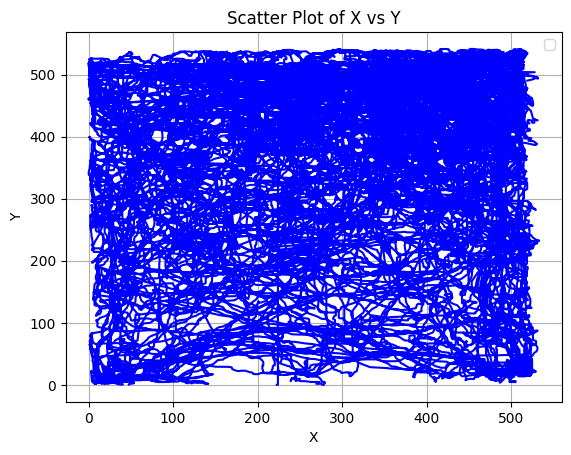

In [33]:
import matplotlib.pyplot as plt
x = xy[:, 0]  # First column (x coordinates)
y = xy[:, 1]  # Second column (y coordinates)

# Create the scatter plot
plt.plot(x, y, color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of X vs Y')
plt.legend()
plt.grid(True)
plt.show()